## Building matched lightcurves

### Importing the packages

In [1]:
import os
os.environ['SCRATCH']='/global/cscratch1/sd/bos0109'
SCRATCH = %env SCRATCH

In [2]:
import sqlite3

In [3]:
from glob import glob

In [4]:
import numpy as np

In [5]:
import lsst.afw.cameraGeom
import lsst.afw.geom as afwGeom
import lsst.geom as geom

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [60]:
sns.set_context('notebook')

In [8]:
from astropy import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

In [9]:
from lsst.afw.geom import makeSkyWcs
from lsst.daf.persistence import Butler
from lsst.obs.lsst.imsim import ImsimMapper

In [31]:
template_repo = '/global/cscratch1/sd/bos0109/templates_rect'
tmprepo = template_repo + '/rerun/multiband'

diarepo = template_repo + '/rerun/diff_rect'
assocrepo = diarepo + '/rerun/assoc_thirrun'
forcerepo = assocrepo + '/rerun/forcedPhot' 

diabutler = Butler(diarepo)

### Loading the stored tables

In [10]:
sntab = pd.read_csv(f'{SCRATCH}/results/sntab_matched.csv')

In [11]:
sntab.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'htmid_level_6', 'galaxy_id', 'c_in',
       'mB', 't0_in', 'x0_in', 'x1_in', 'z_in', 'snid_in', 'snra_in',
       'sndec_in', 'Nobserv', 'N_trueobserv', 'matched', 'match_ang_dist',
       'dia_row', 'dia_id', 'tract', 'patch', 'n_dia_detections'],
      dtype='object')

In [12]:
snlcs = pd.read_csv('/global/u2/b/bos0109/run2_diaproc/lightcurves/sn_matched_lcs.csv')

In [13]:
snlcs.columns

Index(['Unnamed: 0', 'observable', 'observed', 'flux', 'fluxErr', 'mag',
       'magErr', 'mjd', 'filter', 'visitn', 'epoch_DIAmatch', 'SN_id'],
      dtype='object')

In [14]:
diaO = pd.read_csv(f'{SCRATCH}/results/diaObject_table.csv')

In [15]:
diaO.columns

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'nobs',
       'base_PsfFlux_instFlux_Mean_u', 'base_PsfFlux_instFlux_Ndata_u',
       'base_PsfFlux_instFlux_Sigma_u', 'base_PsfFlux_instFlux_MeanErr_u',
       'base_PsfFlux_instFlux_Mean_g', 'base_PsfFlux_instFlux_Ndata_g',
       'base_PsfFlux_instFlux_Sigma_g', 'base_PsfFlux_instFlux_MeanErr_g',
       'base_PsfFlux_instFlux_Mean_r', 'base_PsfFlux_instFlux_Ndata_r',
       'base_PsfFlux_instFlux_Sigma_r', 'base_PsfFlux_instFlux_MeanErr_r',
       'base_PsfFlux_instFlux_Mean_i', 'base_PsfFlux_instFlux_Ndata_i',
       'base_PsfFlux_instFlux_Sigma_i', 'base_PsfFlux_instFlux_MeanErr_i',
       'base_PsfFlux_instFlux_Mean_z', 'base_PsfFlux_instFlux_Ndata_z',
       'base_PsfFlux_instFlux_Sigma_z', 'base_PsfFlux_instFlux_MeanErr_z',
       'base_PsfFlux_instFlux_Mean_y', 'base_PsfFlux_instFlux_Ndata_y',
       'base_PsfFlux_instFlux_Sigma_y', 'base_PsfFlux_instFlux_MeanErr_y',
       'tract', 'patch', 'match', 'sn_row', 'match_ang_dist', 

In [16]:
diaSrc_store = pd.HDFStore(f'{SCRATCH}/results/diaSrc_secrun_fulltables_v5.h5', mode='r+')
diaSrc_store.open()

In [17]:
lcs = diaSrc_store['lightcurves']

In [18]:
lcs.columns

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative',
       'base_NaiveCentroid_x', 'base_NaiveCentroid_y',
       'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts',
       'base_NaiveCentroid_flag_edge',
       ...
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge', 'visit_n', 'filter', 'raft',
       'sensor', 'detector', 'epoch_matched', 'diaObjectId'],
      dtype='object', length=255)

In [19]:
diasrcs = diaSrc_store['matched_tab']

In [20]:
diaSrc_store.close()

Add the MJD to the table if doesn't exist

In [40]:
for vname, group in lcs.groupby('visit_n'):
    mjd = diabutler.get('calexp', visit=vname, detector=10).getInfo().getVisitInfo().getDate().get()
    lcs.loc[group.index, 'mjd'] = mjd

In [186]:
#for vname, group in lcs.groupby('visit_n'):
#    mjd = diabutler.get('calexp', visit=vname, detector=10).getInfo().getVisitInfo().getDate().get()
#    lcs.loc[group.index, 'mjd'] = mjd

In [41]:
fluxes_to_calibrate = ['base_PsfFlux_instFlux',
                       'ip_diffim_forced_PsfFlux_instFlux',
                       'base_CircularApertureFlux_3_0_instFlux',
                       'base_CircularApertureFlux_4_5_instFlux',
                       'base_CircularApertureFlux_6_0_instFlux',
                       'base_CircularApertureFlux_9_0_instFlux',
                       'base_CircularApertureFlux_12_0_instFlux', 
                       'base_CircularApertureFlux_17_0_instFlux', 
                       'base_CircularApertureFlux_25_0_instFlux']

In [42]:
for aflux in fluxes_to_calibrate:
    lcs[aflux+'_nJy'] = np.nan 
    lcs[aflux+'_nJyErr'] = np.nan 
    lcs[aflux+'_calMag'] = np.nan 
    lcs[aflux+'_calMagErr'] = np.nan 

In [43]:
for name, srccat in lcs.groupby(
    ['visit_n', 'detector']):
    vn, det = name
    vn = int(vn)
    det= int(det)
    
    #mjd = diabutler.get('calexp', visit=vn, detector=det).getInfo().getVisitInfo().getDate().get()
    #lcs.loc[srccat.index, 'mjd'] = mjd

    photcal = diabutler.get('deepDiff_differenceExp_photoCalib', 
                    visit=vn, detector=det)
    for id_src, asrc in srccat.iterrows():
        for aflux in fluxes_to_calibrate:
            flux, err = asrc[aflux], asrc[aflux+'Err'] 
            #print(flux, err)
            cal = photcal.instFluxToMagnitude(flux, err)
            lcs.loc[id_src, aflux+'_calMag'] = cal.value
            lcs.loc[id_src, aflux+'_calMagErr'] = cal.error
            cal = photcal.instFluxToNanojansky(flux, err)
            lcs.loc[id_src, aflux+'_nJy'] = cal.value
            lcs.loc[id_src, aflux+'_nJyErr'] = cal.error

### Go for one supernova

Pick a matched supernova

In [44]:
asn = sntab[sntab.matched].iloc[0]

In [45]:
asn

Unnamed: 0                          4
Unnamed: 0.1                        4
htmid_level_6                    9197
galaxy_id                  3375026039
c_in                        0.0123852
mB                            21.3205
t0_in                         59805.8
x0_in                     4.71029e-05
x1_in                        -1.02478
z_in                         0.208735
snid_in                    MS_9172_56
snra_in                       57.5688
sndec_in                     -31.1437
Nobserv                           367
N_trueobserv                       23
matched                          True
match_ang_dist              0.0274345
dia_row                         15492
dia_id              20407623006290377
tract                            4432
patch                             6,6
n_dia_detections                   65
Name: 1, dtype: object

Then we get the TRUTH lightcurve

In [46]:
asn_lc = snlcs[snlcs['SN_id'] == asn.snid_in]

(array([ 0.,  0.,  7.,  4.,  4.,  5., 22.,  6.,  5.,  0.,  0.]),
 array([20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ,
        25.5]),
 <a list of 11 Patch objects>)

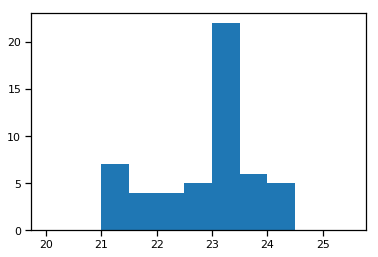

In [61]:
bins = np.arange(20, 26, 0.5)
plt.hist(asn_lc.mag, bins=bins)

In [62]:
bandpass_colors = {}
bandpass_colors['u'] = 'violet'
bandpass_colors['g'] = 'green'
bandpass_colors['r'] = 'red'
bandpass_colors['i'] = 'darkred'
bandpass_colors['z'] = 'violet'
bandpass_colors['y'] = 'blue'

In [63]:
plot_colors = [bandpass_colors[flt] for flt in asn_lc['filter']]

In [64]:
def plot_multifilterLC(lc, ax):
    for aflt, group in lc.groupby('filter'):
        #ax.plot(group.mjd, group.mag, 'o', color=bandpass_colors[aflt], label=aflt)
        ax.errorbar(group.mjd, group.mag, group.magErr, fmt='.',
                    color=bandpass_colors[aflt], label=aflt)
    return ax

Text(0.5, 0, 'MJD')

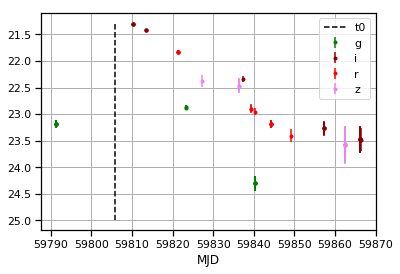

In [65]:
fig, ax = plt.subplots(1, 1)
#ax.title('Truth LC SN={} @z={}'.format(asn.snid_in, asn.z_in))
plot_multifilterLC(asn_lc, ax)
ax.vlines(asn.t0_in, ymin=asn_lc.mag.min(), ymax=25., linestyles='--', label='t0')
ax.invert_yaxis()
ax.legend()
ax.grid()
ax.set_xlabel('MJD')

Get the matched observed light curve

In [66]:
#this way of associating sources is corrupted in this version, because of galaxyId
adiao = diaO[diaO['sn_id'] == asn.galaxy_id]

In [67]:
#thisone seem much more reliable
adiao = diaO[diaO['id'] == asn.dia_id]

In [68]:
adiao

,id,coord_ra,coord_dec,parent,nobs,base_PsfFlux_instFlux_Mean_u,base_PsfFlux_instFlux_Ndata_u,base_PsfFlux_instFlux_Sigma_u,base_PsfFlux_instFlux_MeanErr_u,base_PsfFlux_instFlux_Mean_g,...,base_PsfFlux_instFlux_Mean_y,base_PsfFlux_instFlux_Ndata_y,base_PsfFlux_instFlux_Sigma_y,base_PsfFlux_instFlux_MeanErr_y,tract,patch,match,sn_row,match_ang_dist,sn_id
15492,20407623006290377,1.004766,-0.54356,0,66,NaN,0,NaN,NaN,33.01306,...,NaN,0,NaN,NaN,4640,"5,0",True,1,0.027435,3375026039


In [69]:
adiao['id'].values[0]

20407623006290377

In [70]:
adialc = lcs[lcs['diaObjectId']==adiao['id'].values[0]]

In [71]:
adialc

,id,coord_ra,coord_dec,parent,flags_negative,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,...,base_CircularApertureFlux_12_0_instFlux_calMagErr,base_CircularApertureFlux_17_0_instFlux_nJy,base_CircularApertureFlux_17_0_instFlux_nJyErr,base_CircularApertureFlux_17_0_instFlux_calMag,base_CircularApertureFlux_17_0_instFlux_calMagErr,base_CircularApertureFlux_25_0_instFlux_nJy,base_CircularApertureFlux_25_0_instFlux_nJyErr,base_CircularApertureFlux_25_0_instFlux_calMag,base_CircularApertureFlux_25_0_instFlux_calMagErr,mjd
313101,10702592027918474,1.004767,-0.543560,0,False,1836.035298,58.080751,False,False,False,...,0.236548,1303.985371,375.880447,23.611818,0.312969,1192.274477,540.626800,23.709059,0.492318,59791.353708
318652,10703470415839413,1.004765,-0.543560,0,False,1428.307483,2518.372851,False,False,False,...,0.197259,1170.594270,374.845761,23.728984,0.347673,1560.956076,540.262193,23.416523,0.375784,59791.360480
343701,11717346838184040,1.004766,-0.543560,0,False,3023.264735,3056.077090,False,False,False,...,0.104907,8825.768849,1199.972990,21.535619,0.147619,9434.821267,1737.234782,21.463166,0.199917,59810.381776
346790,11910491450376313,1.004766,-0.543560,0,False,3587.016334,2598.171160,False,False,False,...,0.117898,7182.609663,1021.842962,21.759294,0.154464,5330.266704,1470.345113,22.083128,0.299499,59813.399230
204176,12204958166286451,1.004766,-0.543560,0,False,3230.177845,1307.352390,False,False,False,...,0.091042,5693.638466,628.578816,22.011525,0.119865,5733.567462,899.089970,22.003938,0.170256,59821.276024
210423,12211470209122368,1.004766,-0.543560,0,False,2988.027804,3049.039935,False,False,False,...,0.091641,5569.030443,606.770356,22.035551,0.118296,4115.464775,865.823445,22.363953,0.228420,59821.320604
199502,12340793956106335,1.004766,-0.543559,0,False,1806.256267,677.097005,False,False,False,...,0.138824,1490.308903,349.694609,23.466809,0.254763,1874.288590,502.674624,23.217909,0.291189,59823.345649
189892,12843101789880355,1.004765,-0.543560,0,False,1684.811380,1238.620584,False,False,False,...,0.334815,4984.874340,2319.617571,22.155864,0.505227,7464.782048,3386.301969,21.717457,0.492530,59836.337963
117674,14758726795788404,1.004767,-0.543560,0,False,1700.054141,3838.058763,False,False,False,...,0.454282,-1129.033973,643.860951,NaN,0.619169,-659.402775,924.811547,NaN,1.522744,59877.126785
136329,15293515588173866,1.004766,-0.543560,0,False,2548.024121,241.087217,False,False,False,...,0.270090,-2668.132711,1516.870029,NaN,0.617256,-2709.214368,2215.585037,NaN,0.887911,59887.175849


In [72]:
def plot_dia_multifilterLC(lc, ax):
    for aflt, group in lc.groupby('filter'):
        ax.errorbar(group.mjd, group.base_PsfFlux_instFlux_calMag, 
                    group.base_PsfFlux_instFlux_calMagErr, fmt='x',
                    color=bandpass_colors[aflt], lw=1.5,
                    label='DIA '+aflt)
    return ax

Text(0.5, 0, 'MJD')

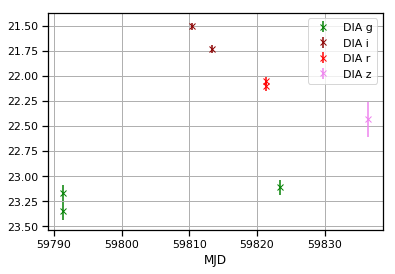

In [73]:
fig, ax = plt.subplots(1, 1)
#ax.title('Truth LC SN={} @z={}'.format(asn.snid_in, asn.z_in))
plot_dia_multifilterLC(adialc, ax)
#ax.vlines(asn.t0_in, ymin=adialc.mag.min(), ymax=25., linestyles='--', label='t0')
ax.invert_yaxis()
ax.legend()
ax.grid()
ax.set_xlabel('MJD')

Text(0, 0.5, 'mag')

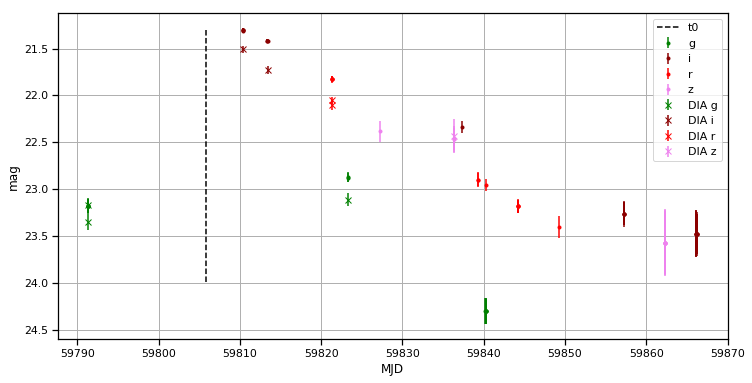

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#ax.title('Truth LC SN={} @z={}'.format(asn.snid_in, asn.z_in))
plot_multifilterLC(asn_lc, ax)
plot_dia_multifilterLC(adialc, ax)
ax.vlines(asn.t0_in, ymin=asn_lc.mag.min(), ymax=24., linestyles='--', label='t0')
ax.invert_yaxis()
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('MJD')
ax.set_ylabel('mag')

### For more lightcurves

In [75]:
asn = sntab[sntab.matched].iloc[1]
asn_lc = snlcs[snlcs['SN_id'] == asn.snid_in]
#adiao = diaO[diaO['sn_id'] == asn.galaxy_id]
adiao = diaO[diaO['id'] == asn.dia_id]
adialc = lcs[lcs['diaObjectId']==adiao['id'].values[0]]

Text(0, 0.5, 'mag')

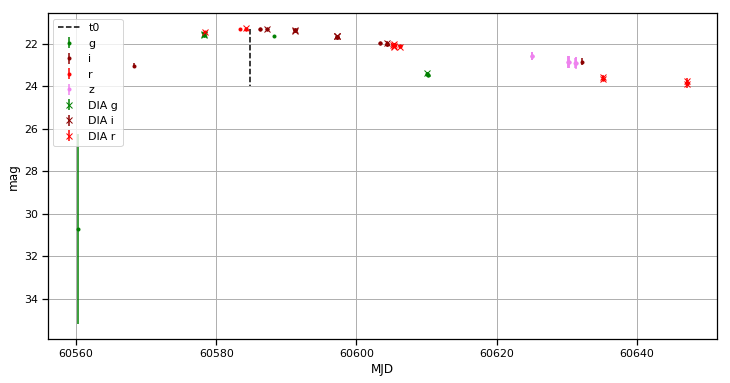

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#ax.title('Truth LC SN={} @z={}'.format(asn.snid_in, asn.z_in))
plot_multifilterLC(asn_lc, ax)
plot_dia_multifilterLC(adialc, ax)
ax.vlines(asn.t0_in, ymin=asn_lc.mag.min(), ymax=24., linestyles='--', label='t0')
ax.invert_yaxis()
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('MJD')
ax.set_ylabel('mag')

In [84]:
for asn in sntab[sntab.matched].itertuples():
    asn_lc = snlcs[snlcs['SN_id'] == asn.snid_in]
    #adiao = diaO[diaO['sn_id'] == asn.galaxy_id]
    adiao = diaO[diaO['id'] == asn.dia_id]
    adialc = lcs[lcs['diaObjectId']==adiao['id'].values[0]]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title('Truth LC SN={} at z={}'.format(asn.snid_in, asn.z_in))
    
    plot_multifilterLC(asn_lc, ax)
    plot_dia_multifilterLC(adialc, ax)
    ax.vlines(asn.t0_in, ymin=asn_lc.mag.min(), 
              ymax=np.min([asn_lc.mag.max(), 28.]), 
              linestyles='--', label='t0')
    ax.invert_yaxis()
    ax.legend(loc='best')
    ax.grid()
    ax.set_xlabel('MJD')
    ax.set_ylabel('mag')
    plt.savefig('graphs/lightcurve_asn_id_{}.png'.format(asn.snid_in))
    plt.clf()

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [ ]:
for asn in sntab[sntab.matched].itertuples():
    asn_lc = snlcs[snlcs['SN_id'] == asn.snid_in]
    #adiao = diaO[diaO['sn_id'] == asn.galaxy_id]
    adiao = diaO[diaO['id'] == asn.dia_id]
    adialc = lcs[lcs['diaObjectId']==adiao['id'].values[0]]
